ETF DASHBOARD V.2.0

# | Financial Analyzer
- *Financial Data Source: Yahoo Finance (Quarterly Reporting)*
- *Insprired from Piotroski F-score metric witten by Joseph Piotroski https://www.investopedia.com/terms/p/piotroski-score.asp*
- *Altman Z Score*
- *https://codingandfun.com/profitability-analysis-with-python/*

In [165]:
# Author: Ken Lee and William 2020.01.12
# Our Library
import ETFFundamentalData as finData
import ETFHistoryDownload as hist
import ETFStockAnalytics as analytic
import ETFPerformanceForecast as perf
# Common Library
import sqlalchemy as sql
import hvplot.pandas
import numpy as np
from pandas import ExcelWriter
import pandas as pd
#import datetime
import time
import os
from pathlib import Path
import logging
from dateutil.relativedelta import relativedelta
from datetime import datetime
# DB Connection
eft_data_connection_string = 'sqlite:///./Resources/etf.db'
our_portfolio_export = Path('./Resources/our_portfolio.csv')
etf_data_engine = sql.create_engine(eft_data_connection_string, echo=True)
# IF REQUIRED TO RELOAD - SET TRUE
RELOAD_DATA = False


## STEP1. FINANCIAL DATA DOWNLOAD FROM YAHOO FINANCE

In [2]:
if RELOAD_DATA == True:

    hist.drop_table('FUNDAMENTAL_DATA')

    sql_query = """
    SELECT distinct symbol as name
    FROM STOCK_HISTORY
    UNION
    SELECT 'SPY'
    """
    etf_symbols_exist = pd.read_sql_query(sql_query, eft_data_connection_string)
    display(etf_symbols_exist)
    output_df = finData.create_df_by_df_symbol(etf_symbols_exist)
    display(output_df)
    output_df = finData.download_fundamentalData_by_df_Symbol(output_df, etf_symbols_exist)
    display(output_df)
    result_data = finData.get_fundamentalData(output_df)   
    display(result_data)

## STEP2. FINANCIAL DATA COLLECTION 
### 1. Industry Sector Report 
- *Source: financialVisualizations https://finviz.com/screener.ashx?v=161*

In [3]:
# Read Industry Report CSV file into DataFrame df
RELOAD_DATA = True
if RELOAD_DATA == True:
    industry_report_df = pd.read_csv('.//Resources//etf_industrial_perf_by_sector.csv', index_col=0)

# Show dataframe
display(industry_report_df)

,Stocks,MarketCap,PE_Trailing,PE_FWD,PEG_FWD,PS_12m,Price_to_Book,Dividend_Yield,EPS_Trailing,EPS_Growth,...,Perf_M,Perf_Q,Perf_HY,Perf_Y,Perf_YTD,Rating_RecommendMean,Volume_AVG,Volume_RELATIVE,PxChange,Volume
Sector,,,,,,,,,,,,,,,,,,,,,
Basic Materials,265,2333447.35,12.68,15.57,0.90,1.70,2.34,0.0374,0.2977,0.1412,...,0.0476,0.0905,0.0102,0.0751,0.0099,2.21,458908.29,0.91,0.0175,416568601
Communication Services,289,8191924.22,24.71,16.76,1.17,3.86,3.64,0.0072,0.1780,0.2106,...,-0.0292,-0.0311,-0.0408,0.1835,-0.0246,1.89,697553.00,0.99,0.0131,689195223
Consumer Cyclical,566,8361344.18,30.32,17.70,0.96,1.26,4.12,0.0061,0.2756,0.3154,...,-0.0226,0.0265,-0.0085,0.0198,-0.0150,2.06,1186285.49,0.93,0.0168,1101584102
Consumer Defensive,252,3859638.52,26.96,23.30,2.78,1.47,4.27,0.0225,0.0668,0.0970,...,0.0305,0.0759,0.0309,0.0740,-0.0057,2.23,537820.10,1.21,0.0002,651658333
Energy,281,3270152.86,17.05,9.34,1.47,0.88,1.17,0.0456,-0.1072,0.1157,...,0.0981,0.0658,0.1968,0.3490,0.1133,2.18,671812.79,1.05,0.0325,706829699
Financial,1480,10658499.85,13.62,15.69,1.01,1.78,1.17,0.0172,0.0763,0.1347,...,0.0561,0.0495,0.0744,0.2219,0.0483,2.20,898787.08,0.97,0.0121,873011209
Healthcare,1291,8011210.51,28.73,16.87,2.25,2.35,1.17,0.0141,0.0991,0.1278,...,0.0028,0.0217,-0.0061,0.0448,-0.0375,2.05,1677938.39,0.72,0.0075,1205729664
Industrials,632,5205617.41,26.78,19.17,1.73,2.16,1.17,0.0129,0.0501,0.1552,...,-0.0013,0.0507,0.0372,0.1486,-0.0094,2.27,625278.79,0.81,0.0079,506417226
Real Estate,287,1881819.28,31.24,36.98,2.90,6.13,1.17,0.0272,0.0605,0.1076,...,0.0017,0.0528,0.0397,0.2632,-0.0419,2.22,305658.98,0.91,0.0036,279025500


### 2. Our SockPool Baseline (Pool AVG)

In [90]:
sql_query = """
    SELECT Sector, Count(Name) as Stocks, Sum(MarketCap) As MarketCap, AVG(PE_Trailing) AS PE_Trailing, AVG(PE_FWD) AS PE_FWD, AVG(PEG_Trailing) AS PEG_Trailing, AVG(PS_12m) AS PS_12m, AVG(Price_to_Book) AS Price_to_Book, AVG(Total_Cash_per_Share) AS Total_Cash_per_Share, AVG(Margin_EBITDA) AS Margin_EBITDA, AVG(Margin_Gross) AS Margin_Gross, AVG(Margin_Operation) AS Margin_Operation, AVG(Return_on_Equity) AS Return_on_Equity, AVG(Return_on_Asset) AS Return_on_Asset, AVG(EPS_Trailing) AS EPS_Trailing, AVG(Earning_Growth) AS Earning_Growth, AVG(Earning_QuarterGrowth) AS Earning_QuarterGrowth, AVG(Return_on_Asset) AS Return_on_Asset, AVG(Return_on_Equity) AS Return_on_Equity, AVG(Margin_Gross) AS Margin_Gross, AVG(Margin_Operation) AS Margin_Operation, AVG(Margin_Profit) AS Margin_Profit, AVG(Revenue_per_share) AS Revenue_per_share, AVG(Dividend_TrailingAnnual) AS Dividend_TrailingAnnual, AVG(Dividend_Yield) AS Dividend_Yield
    FROM FINANCIAL_DATA group by sector
    """
sector_list = pd.read_sql_query(sql_query, eft_data_connection_string)
sector_list

,Sector,Stocks,MarketCap,PE_Trailing,PE_FWD,PEG_Trailing,PS_12m,Price_to_Book,Total_Cash_per_Share,Margin_EBITDA,...,Earning_Growth,Earning_QuarterGrowth,Return_on_Asset,Return_on_Equity,Margin_Gross,Margin_Operation,Margin_Profit,Revenue_per_share,Dividend_TrailingAnnual,Dividend_Yield
0,Basic Materials,17,494352134912,38.882741,25.653947,1.070500,3.694660,5.749697,5.322471,0.202247,...,1.615818,1.579727,0.078883,0.206193,0.319152,0.142164,0.092638,57.170882,0.009964,0.012953
1,Communication Services,21,6512102673152,71.031091,129.327650,1.482529,8.029298,6.584436,32.262143,0.258359,...,0.943250,0.951562,0.065936,0.159856,0.583762,0.162933,0.132690,79.381190,0.026624,0.030414
2,Consumer Cyclical,49,4521617352704,67.233453,23.136616,1.705569,3.731361,25.246637,17.899408,0.175688,...,1.193486,1.188216,0.118460,0.851992,0.377950,0.144822,0.104560,128.969286,0.008700,0.013156
3,Consumer Defensive,19,2222546739200,68.862470,33.926965,2.241700,4.487079,11.650735,5.112263,0.202988,...,0.019200,0.011733,0.087751,0.439471,0.425468,0.176288,0.113708,87.187211,0.026784,0.028650
4,Energy,10,521697599616,21.421320,12.553005,1.030900,1.849324,2.595296,2.967900,0.149486,...,0.986333,0.555333,-0.008206,-5.125323,0.453209,-0.054827,-0.167901,31.571900,0.021713,0.022714
5,Financial,1,3070635264,NaN,NaN,NaN,62.932537,NaN,0.154000,0.000000,...,0.952000,0.232000,0.014040,-0.175440,1.000000,0.920540,0.000000,3.082000,NaN,NaN
6,Financial Services,61,3913335492736,36.895569,10.808888,2.404500,6.120640,7.023573,104.709623,0.133984,...,0.856849,0.862679,0.037823,0.280222,0.377854,0.355268,0.276931,48.959787,0.017480,0.018060
7,Healthcare,62,4355060083072,101.700440,25.344608,3.093594,8.973350,14.161911,15.852871,0.187051,...,0.771721,0.745705,0.077303,0.304854,0.531788,0.137453,0.086739,70.472484,0.013815,0.015612
8,Industrials,74,2800806763136,40.398390,27.995153,1.576660,3.883297,6.739856,6.998459,0.192801,...,0.722015,0.745354,0.076911,0.240378,0.330481,0.148815,0.097290,61.858000,0.010556,0.012393
9,Real Estate,118,1582878173568,82.926598,53.111483,7.649010,10.167886,3.844686,2.039873,0.531216,...,1.749165,1.560213,0.021100,0.057406,0.640922,0.235726,0.141063,9.602534,0.029263,0.034287


### 3. Our Selected Stocks (Portfolio)

In [5]:
our_portfolio_df = pd.read_csv(our_portfolio_export)
fin_matrix = finData.get_finData(our_portfolio_df)   
display(fin_matrix["Sector"].value_counts())
fin_matrix.drop('index', axis=1, inplace=True)
fin_matrix.set_index("Symbol", inplace = True)
display(fin_matrix.head())

a


Technology                24
Consumer Cyclical          7
Industrials                4
Healthcare                 4
Communication Services     4
Real Estate                3
Consumer Defensive         2
Financial Services         1
Basic Materials            1
Name: Sector, dtype: int64

,Sector,Name,Date_MostRecentQuarter,Date_LastDividend,Date_LastFiscalYearEnd,Date_NextFiscalYearEnd,Beta,BookValue,Debt_to_Equity,Divedend_Rate,...,Revenue_per_share,TargetPX_High,TargetPX_low,TargetPX_Mean,TargetPX_Median,Total_Cash,Total_Cash_per_Share,Total_Debt,Total_Revenue,Volume_10dAvg
Symbol,,,,,,,,,,,,,,,,,,,,,
ACN,Technology,Accenture plc,2021-05-31 00:00:00,None,2020-08-31 00:00:00,2022-08-31 00:00:00,1.107584,28.802,17.331,3.52,...,75.472,365,290,328.71,330,10013812736,15.791,3447866112,47949377536,2025050
AMAT,Technology,"Applied Materials, Inc.",2021-08-01 00:00:00,None,2020-10-25 00:00:00,2022-10-25 00:00:00,1.437227,13.122,47.421,0.96,...,23.65,195,128,162.47,161,6510000128,7.210,5719000064,21628000256,5356320
AMD,Technology,"Advanced Micro Devices, Inc.",2021-09-25 00:00:00,None,2020-12-26 00:00:00,2022-12-26 00:00:00,2.030978,5.888,9.837,None,...,12.249,180,101.5,142.5,140,3608000000,2.988,702000000,14851999744,50426990
APPS,Technology,"Digital Turbine, Inc.",2021-06-30 00:00:00,None,2021-03-31 00:00:00,2023-03-31 00:00:00,2.194708,1.612,51.976,None,...,5.216,132,68,102.5,102.5,83129000,0.865,273796992,467182016,4401080
ARWR,Healthcare,"Arrowhead Pharmaceuticals, Inc.",2021-06-30 00:00:00,None,2020-09-30 00:00:00,2022-09-30 00:00:00,1.260846,4.283,5.526,None,...,1.042,106,44,87.92,91,516312000,4.952,24144000,107637064,598540


# STEP3. FINANCIAL ANALYSIS SCORING MODEL
*DUE TO DATA LIMITATION (NO QUARTERLY DATA -- ONLY LATEST), USE SIMPLIFIED Z-SCORE and F-SCORE GRADING MODEL USING GROWTH RATE INSTEAD*

## I. Altman Z-Score 
##### The Altman Z-score is the output of a credit-strength test that gauges a publicly traded manufacturing company's likelihood of bankruptcy.
##### *https://corporatefinanceinstitute.com/resources/knowledge/credit/altmans-z-score-model/*
#### Z-Score = 1.2A + 1.4B + 3.3C + 0.6D + 1.0E
##### *Where:*
- A = CurrentRatio   'Ratio_Current'   <- ORIG: (working capital / total assets)
- B = ReturnOnAssets 'Return_on_Asset' <- ORIG: (retained earnings / total assets)
- C = ebitdaMargins  'Margin_EBITDA'   <- ORIG: (earnings before interest and tax / total assets)
- D = QuickRatio     'Ratio_Quick'     <- ORIG: (market value of equity / total liabilities)   -- SKIPPED
- E = priceToSalesTrailing12Months 'PS_12m'  <- ORIG: (sales / total assets)


In [77]:
#S Altman Score Matrix Result
#display(fin_matrix['Ratio_Quick'].head()) -- omit for data availability
def calc_z_score(p_fin_matrix):
    l_z_score_matrix = p_fin_matrix[['Sector','Ratio_Current','Return_on_Asset','Margin_EBITDA','PS_12m']].copy() #,'Return_on_Equity']].copy()
    l_z_score_matrix = l_z_score_matrix.dropna()
    l_z_score_matrix['Z_Score'] = 1.2 * (l_z_score_matrix['Ratio_Current']) + (1.4 * (l_z_score_matrix['Return_on_Asset'])) + (3.3 * (l_z_score_matrix['Margin_EBITDA'].apply(lambda x: float(x))))+(1.0 * ((l_z_score_matrix['PS_12m'])/10 )) 
    l_z_score_matrix = l_z_score_matrix.sort_values(by=['Z_Score'], ascending=False)
    return l_z_score_matrix[['Sector','Return_on_Asset','Z_Score']]

## II. Piotroski F-Score
#### The Piotroski F-Score is a financial indicator designed by accounting professor Joseph Piotroski which puts together nine criteria to evaluate the financial strength of a  business based on its profitability, leverage, liquidity, source of funds, and operating efficiency.
#### F-Score = ROA_FS + CFO_FS + ROA_D_FS + CFO_ROA_FS + LTD_FS + CR_FS + DILUTION_FS + GM_FS + ATO_FS   
#### *https://finbox.com/blog/piotroski-f-score-explained/*
##### *Threashold* #####
###### - ROA_Limit: 0.15 | CR_Limit: 2.0 | TCS_Limit: 4.0 | GM_Limit: 0.20 | RG_Limit: 0.20 | EG_Limit: 0.30

##### *Profitability*
- ROA_FS = IF(returnOnAsset => ROA_Limit, 1, 0)  <- ORIG: Return on Assets (1 point);
- CFO_FS = IF(OperatingCashflow > 0, 1, 0)       <- ORIG: Operating Cash Flow (1 point);
- ROA_D_FS = IF(netIncome > OperatingCashflow, 1, 0) <-ORIG: Change in ROA (1 point);
##### *Leverage, Liquidity and Source of Funds*
- CR_FS = IF(CurrentRatio => CR_Limit, 1, 0)     <- ORIG: CR_FS Change in Current ratio (1 point);
- DILUTION_FS = IF(totalCashPerShare => TCS_Limit, 1, 0)  <- ORIG: IF(totalCashPerShareChange in the number of shares (1 point)
##### *Operating Efficiency and Growth*
- GM_FS = IF(profitMargins Change => GM_Limit, 1, 0) in Gross Margin (1 point);
- ATO_FS = IF(revenueGrowth Change => RG_limit, 1, 0) in Asset Turnover ratio (1 point);
- E_FS = IF(Earning_Growth Change => EG_Limit, 1, 0) in Earning Growth (1 point);

In [78]:
#F Piotroski Score Matrix Result
# Treashold Limit
def calc_f_score(p_fin_matrix):
    ROA_LIMIT = 0.15  #15%
    CR_LIMIT =  2.0   #2.0
    TCS_LIMIT =  4.0  #4
    GM_LIMIT =  0.20  #20%
    RG_LIMIT = 0.20   #20%
    EG_LIMIT =  0.30  #30%

    l_f_score_matrix = p_fin_matrix[['Sector','Return_on_Asset','Ratio_Current','Total_Cash_per_Share','Margin_Profit','Earning_Growth']].copy() #,'Return_on_Equity']].copy()
    l_f_score_matrix = l_f_score_matrix.dropna()
    l_f_score_matrix['ROA_FS'] =  [1 if x >= ROA_LIMIT else 0 for x in l_f_score_matrix['Return_on_Asset']]
    l_f_score_matrix['CR_FS'] =  [1 if x >= CR_LIMIT else 0 for x in l_f_score_matrix['Ratio_Current']]
    l_f_score_matrix['DILUTION_FS'] =  [1 if x >= TCS_LIMIT else 0 for x in l_f_score_matrix['Total_Cash_per_Share']]
    l_f_score_matrix['GM_FS'] =  [1 if x >= GM_LIMIT else 0 for x in l_f_score_matrix['Margin_Profit'].apply(lambda x: float(x))]
    l_f_score_matrix['E_FS'] =  [1 if x >= EG_LIMIT else 0 for x in l_f_score_matrix['Earning_Growth'].apply(lambda x: float(x))]
    l_f_score_matrix['F_Score'] = l_f_score_matrix['ROA_FS'] + l_f_score_matrix['CR_FS'] + l_f_score_matrix['DILUTION_FS'] + l_f_score_matrix['GM_FS'] + l_f_score_matrix['E_FS']
    l_f_score_matrix = l_f_score_matrix.sort_values(by=['F_Score'], ascending=False)
    return l_f_score_matrix[['F_Score']]



In [79]:
z_score_matrix = calc_z_score(fin_matrix)
print("TOP 5 BEST Z-SCORE")
display(z_score_matrix.head())
print("BOTTOM 5 WORST Z-SCORE")
display(z_score_matrix.tail())


TOP 5 BEST Z-SCORE


,Sector,Return_on_Asset,Z_Score
Symbol,,,
SWKS,Technology,0.15460,11.437245
VICR,Technology,0.08002,10.693119
NEO,Healthcare,-0.02188,9.926454
MPWR,Technology,0.10913,8.574721
LSCC,Technology,0.07022,7.816363


BOTTOM 5 WORST Z-SCORE


,Sector,Return_on_Asset,Z_Score
Symbol,,,
UPS,Industrials,0.07768,2.457364
GS,Financial Services,0.01724,2.314274
CBRE,Real Estate,0.05710,2.153270
TGT,Consumer Defensive,0.10204,1.765377
SNBR,Consumer Cyclical,0.19278,1.099980


# STEP4. RESULTS BASED ON FINANCIAL ANALYSIS WITH SIMPLIFIED Z-SCORE AND F-SCORE 

In [80]:
f_score_matrix = calc_f_score(fin_matrix)
    #display(f_score_matrix)
print("TOP 5 BEST F-SCORE")
display(f_score_matrix.head())
print("BOTTOM 5 WORST F-SCORE")
display(f_score_matrix.tail())

TOP 5 BEST F-SCORE


,F_Score
Symbol,
LRCX,5
KLAC,5
SWKS,5
WST,5
AMAT,5


BOTTOM 5 WORST F-SCORE


,F_Score
Symbol,
SNPS,1
SAIA,1
YETI,1
PAYC,0
APPS,0


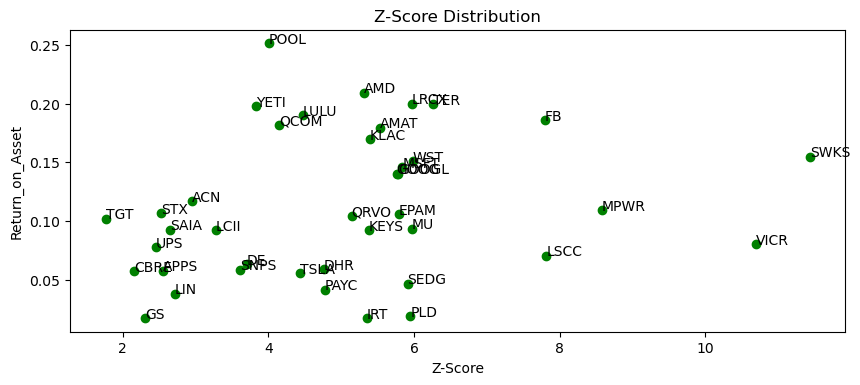

In [87]:
import matplotlib.pyplot as plt

y = score_matrix['Return_on_Asset']
z = score_matrix['Z_Score']
n = score_matrix.index

fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
plt.title('Z-Score Distribution')
plt.xlabel("Z-Score", color="black")
plt.ylabel("Return_on_Asset", color="black")
x = ax.scatter(z, y, color='green')

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]))

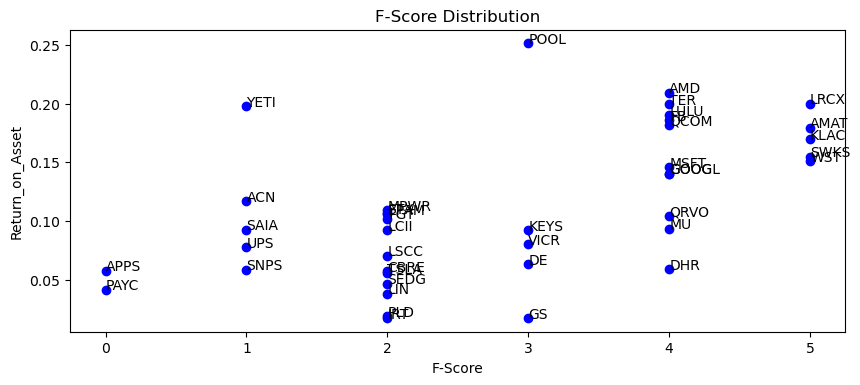

In [86]:
import matplotlib.pyplot as plt

y = score_matrix['Return_on_Asset']
z = score_matrix['F_Score']
n = score_matrix.index

fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
plt.title('F-Score Distribution')
plt.xlabel("F-Score", color="black")
plt.ylabel("Return_on_Asset", color="black")
x = ax.scatter(z, y, color='blue')

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]))

# STEP5. FINANCIAL ANALYSIS SCREENING RESULT 

### 1) UPDATE OUR PORTFOLIO WITH SCORE INTO OUR_PORTFOLIO DB TABLE

In [164]:
#Build and Save our portfolio with ratings into ETF_DB
steady_value_list =  score_matrix[score_matrix['Z_Score'] >= 4]
steady_value_list =  steady_value_list[steady_value_list['F_Score'] >= 3]
steady_value_list['Steady_Value'] = 1 
our_portfolio_df['Symbol'] = our_portfolio_df['symbol']
our_portfolio_df = our_portfolio_df.set_index('Symbol')
our_portfolio_df['Sector'] = score_matrix['Sector']
our_portfolio_df['Z_Score'] = score_matrix['Z_Score']
our_portfolio_df['F_Score'] = score_matrix['F_Score']
our_portfolio_df['Steady_Value'] = steady_value_list['Steady_Value']
our_portfolio_df['Steady_Value'] = our_portfolio_df['Steady_Value'].fillna(0)
our_portfolio_df.drop('symbol', axis=1, inplace=True)
# Store into DB TABLE 'OUR_PORTFOLIO_LIST'
our_portfolio_df.to_sql('OUR_PORTFOLIO_LIST', etf_data_engine, index=True, if_exists='replace')        
display(our_portfolio_df.groupby(['Sector','Symbol']).sum())

2022-01-17 07:57:21,570 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("OUR_PORTFOLIO_LIST")
2022-01-17 07:57:21,571 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-01-17 07:57:21,574 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("OUR_PORTFOLIO_LIST")
2022-01-17 07:57:21,575 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-01-17 07:57:21,580 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-01-17 07:57:21,583 INFO sqlalchemy.engine.Engine 
CREATE TABLE "OUR_PORTFOLIO_LIST" (
	"Symbol" TEXT, 
	"CUR_PX" FLOAT, 
	"SMA_50" FLOAT, 
	"SMA_150" FLOAT, 
	"SMA_200" FLOAT, 
	"SMA_200_20" FLOAT, 
	"HIGH_52WK" FLOAT, 
	"LOW_52WK" FLOAT, 
	"RS_RATING" FLOAT, 
	"Z_Score" FLOAT, 
	"F_Score" FLOAT, 
	"Steady_Value" FLOAT, 
	"Sector" TEXT
)


2022-01-17 07:57:21,584 INFO sqlalchemy.engine.Engine [no key 0.00185s] ()
2022-01-17 07:57:21,604 INFO sqlalchemy.engine.Engine CREATE INDEX "ix_OUR_PORTFOLIO_LIST_Symbol" ON "OUR_PORTFOLIO_LIST" ("Symbol")
2022-01-17 07:57:21,608 INFO sqlalchemy.en

CUR_PX   SMA_50  SMA_150  SMA_200  SMA_200_20  \
Sector                 Symbol                                                   
Basic Materials        LIN      212.85   204.62   197.68   193.18      189.67   
Communication Services FB       205.09   196.92   190.31   187.80      184.41   
                       GOOG    1336.72  1311.80  1214.52  1208.89     1190.00   
                       GOOGL   1338.12  1311.05  1214.97  1210.42     1192.12   
Consumer Cyclical      LCII     107.13   104.12    94.14    92.10       89.77   
                       LULU     231.67   217.58   196.47   189.46      181.79   
                       POOL     212.38   207.43   197.71   191.81      186.87   
                       TSLA     418.17   347.23   270.00   265.00      256.26   
                       YETI      34.76    31.96    30.28    30.21       29.42   
Consumer Defensive     TGT      128.17   119.48   103.27    97.01       92.01   
Financial Services     GS       229.88   221.15   210.09   207.36      204.57   
Healthcare             DHR      153.52   143.69   141.42   138.75      136.23   
                       WST      150.25   147.02   138.50   132.61      128.40   
Industrials            DE       173.21   173.32   164.36   162.45      161.47   
                       SAIA      93.03    94.80    83.08    78.53       76.01   
                       UPS      117.06   119.06   113.90   112.14      111.40   
Real Estate            CBRE      61.26    56.58    53.29    52.42       51.54   
                       IRT       14.09    14.54    13.52    12.81       12.45   
                       PLD       89.13    89.23    84.66    82.03       80.29   
Technology             ACN      210.50   197.39   192.53   188.44      184.30   
                       AMAT      61.04    57.66    50.71    48.48       46.51   
                       AMD       45.87    38.87    33.51    31.97       30.13   
                       APPS       7.14     7.73     6.48     5.79        5.35   
                       EPAM     212.21   199.62   189.66   185.03      180.47   
                       KEYS     102.61   104.24    95.43    93.01       91.19   
                       KLAC     178.19   170.21   147.43   140.22      134.91   
                       LRCX     292.40   274.53   229.49   219.97      209.70   
                       LSCC      19.14    19.27    18.06    16.75       16.09   
                       MPWR     177.87   163.98   150.55   148.05      144.51   
                       MSFT     157.49   149.35   140.61   136.30      132.28   
                       MU        53.77    48.81    44.67    43.59       42.51   
                       PAYC     264.77   243.50   232.72   223.53      215.60   
                       QCOM      88.24    85.75    78.16    76.49       73.36   
                       QRVO     116.23   102.58    81.63    79.28       75.04   
                       SEDG      95.08    85.60    76.71    68.81       64.12   
                       SNPS     139.19   137.21   134.42   130.09      127.01   
                       STX       59.50    58.53    52.02    50.85       49.71   
                       SWKS     120.87   102.66    86.57    85.62       82.64   
                       TER       68.19    64.60    56.31    53.35       50.83   
                       VICR      46.66    40.08    33.88    33.60       32.59   

                               HIGH_52WK  LOW_52WK  RS_RATING    Z_Score  \
Sector                 Symbol                                              
Basic Materials        LIN        212.85    191.49      63.16   2.720224   
Communication Services FB         208.10    182.31      74.53   7.795682   
                       GOOG      1361.17   1242.93      79.97   5.762179   
                       GOOGL     1362.16   1241.18      79.12   5.784185   
Consumer Cyclical      LCII       108.70     94.88      67.15   3.283746   
                       LULU       233.37    194.44      83.19   4.473176   
                     

### 2) REVIEW STEADY VALUE PICKS (BUY AND HOLD WEIGHTED)

In [162]:
#Steady Value List - Weighted to LONG 'BUY AND HOLD'
steady_portfolio = our_portfolio_df[our_portfolio_df['Steady_Value'] > 0]
steady_portfolio = steady_portfolio.sort_values(["F_Score", "Z_Score", 'RS_RATING'], ascending = (False, False, False))
display(steady_portfolio)


,symbol,CUR_PX,SMA_50,SMA_150,SMA_200,SMA_200_20,HIGH_52WK,LOW_52WK,RS_RATING,Z_Score,F_Score,Steady_Value,Sector
Symbol,,,,,,,,,,,,,
SWKS,SWKS,120.87,102.66,86.57,85.62,82.64,122.29,87.56,68.85,11.437245,5.0,1.0,Technology
WST,WST,150.25,147.02,138.50,132.61,128.40,151.14,138.75,93.21,5.983345,5.0,1.0,Healthcare
LRCX,LRCX,292.40,274.53,229.49,219.97,209.70,297.43,232.97,95.59,5.971187,5.0,1.0,Technology
AMAT,AMAT,61.04,57.66,50.71,48.48,46.51,62.37,50.53,94.23,5.532770,5.0,1.0,Technology
KLAC,KLAC,178.19,170.21,147.43,140.22,134.91,178.74,156.37,94.57,5.395209,5.0,1.0,Technology
FB,FB,205.09,196.92,190.31,187.80,184.41,208.10,182.31,74.53,7.795682,4.0,1.0,Communication Services
TER,TER,68.19,64.60,56.31,53.35,50.83,69.62,58.91,95.76,6.254318,4.0,1.0,Technology
MU,MU,53.77,48.81,44.67,43.59,42.51,55.42,43.47,84.72,5.972228,4.0,1.0,Technology
MSFT,MSFT,157.49,149.35,140.61,136.30,132.28,158.95,136.39,86.76,5.838952,4.0,1.0,Technology
